In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from figurefirst import mpl_functions
import seaborn as sns

from mpl_toolkits.axes_grid1 import make_axes_locatable 
import odor_stat_calculations as osc
from scipy.spatial.distance import cdist
import scipy.stats as st


## training
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [3]:

def scale_data(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return (((data - min_val) / (max_val - min_val)) * 10)

In [25]:
class MDN(nn.Module):
    def __init__(self, input_size, hidden_dim, n_gaussians, dropout_rate=0.2):
        super(MDN, self).__init__()   
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.pi = nn.Linear(hidden_dim, n_gaussians)
        # Means (mu's)
        self.mu = nn.Linear(hidden_dim, n_gaussians)
        
        # Variances (sigma's)
        self.sigma = nn.Linear(hidden_dim, n_gaussians)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        pi = F.softmax(self.pi(x), dim=1)
        mu = self.mu(x)
        sigma = torch.exp(self.sigma(x))  # Ensure sigma is positive
        
        return pi, mu, sigma

# def mdn_loss(pi, mu, sigma, target):
#     m = torch.distributions.Normal(loc=mu, scale=sigma)
#     log_prob = m.log_prob(target.unsqueeze(1))
#     log_pi = torch.log(pi)
    
#     # LogSumExp trick to prevent underflow/overflow
#     max_log_prob = log_prob.max(1, keepdim=True)[0]
#     log_sum_exp = max_log_prob + torch.log(torch.exp(log_prob - max_log_prob).sum(1, keepdim=True))
#     log_likelihood = log_sum_exp + log_pi
#     loss = -log_likelihood.sum()
#     return loss

def mdn_loss(pi, mu, sigma, y):
    # Compute the negative log likelihood of y given the mixture model
    m = torch.distributions.Laplace(mu, sigma)
    # log_prob = m.log_prob(y)
    log_prob = m.log_prob(y.unsqueeze(-1))

    weighted_log_prob = log_prob + torch.log(pi)
    negative_log_likelihood = -torch.logsumexp(weighted_log_prob, dim=1).mean()
    return negative_log_likelihood


def create_sequences(feature_tensors, target_tensors, seq_length):
    sequences = []
    targets = []
    for i in range(len(feature_tensors) - seq_length):
        # sequences is of shape (seq_length, num_features)
        sequences.append(feature_tensors[i:i+seq_length])
        targets.append(target_tensors[i+seq_length])
    return torch.stack(sequences), torch.stack(targets)  # (N, seq_length, num_features)



def load_and_preprocess_file(file_path, features, target):
    df = pd.read_hdf(file_path)
    # df[target] = np.log(df[target] + 1e-6) 
    # df[target] = np.log(np.clip(df[target], a_min=1e-6, a_max=None))

    scaler = MinMaxScaler()
    df[features] = scaler.fit_transform(df[features])
    
    feature_tensors = torch.Tensor(df[features].values)
    target_tensors = torch.Tensor(df[target].values)

    feature_tensors = feature_tensors.view(-1, len(features))
    return feature_tensors, target_tensors



def sample_from_output(pi, mu, sigma, num_samples):
    """
    Parameters:
        pi (Tensor): Mixture component weights from the network.
        mu (Tensor): Means of the Gaussian components from the network.
        sigma (Tensor): Standard deviations of the Gaussian components from the network.
        num_samples (int): Number of samples to draw from the distribution.

    Returns:
        np.ndarray: An array of shape (batch_size, num_samples) containing the samples.
    """
    # Get the parameters as numpy arrays
    pi_np = pi.cpu().numpy()
    mu_np = mu.cpu().numpy()
    sigma_np = sigma.cpu().numpy()

    # Prepare an array to hold the samples
    samples = np.zeros((pi_np.shape[0], num_samples))

    # For each item in the batch, sample from the distribution
    for i in range(pi_np.shape[0]):
        # Use the probabilities to pick a component, then sample from it
        component = np.random.choice(np.arange(pi_np.shape[1]), p=pi_np[i])
        samples[i, :] = np.random.normal(mu_np[i, component], sigma_np[i, component], num_samples)

    return samples

def sample_from_laplace_mixture(pi, mu, sigma, num_samples):
    """
    Sample from the Laplace mixture model output by the network.

    Parameters:
        pi (Tensor): Mixture component weights from the network.
        mu (Tensor): Location parameters of the Laplace components from the network.
        sigma (Tensor): Scale parameters of the Laplace components from the network.
        num_samples (int): Number of samples to draw from the distribution.

    Returns:
        np.ndarray: An array of shape (batch_size, num_samples) containing the samples.
    """

    pi_np = pi.cpu().numpy()
    mu_np = mu.cpu().numpy()
    sigma_np = sigma.cpu().numpy()

    samples = np.zeros((pi_np.shape[0], num_samples))


    for i in range(pi_np.shape[0]):
        component = np.random.choice(np.arange(pi_np.shape[1]), p=pi_np[i])
        mu_i = mu_np[i, component]
        sigma_i = sigma_np[i, component]
        u = np.random.uniform(-0.5, 0.5, num_samples)
        pos_u_mask = u > 0
        samples[i, pos_u_mask] = mu_i + sigma_i * np.log(2 * u[pos_u_mask])
        samples[i, ~pos_u_mask] = mu_i - sigma_i * np.log(-2 * u[~pos_u_mask])

    return samples


def predict_on_new_data_mdn(model, file_path, features, target, seq_length, device):
    model.eval()
    feature_tensors, target_tensors = load_and_preprocess_file(file_path, features, target)
    sequences, _ = create_sequences(feature_tensors, target_tensors, seq_length)
    
    with torch.no_grad():
        sequences = sequences.to(device)
        flattened_sequences = sequences.view(sequences.size(0), -1).float()
        pi, mu, sigma = model(flattened_sequences)
        sampled_vals = sample_from_laplace_mixture(pi, mu, sigma, num_samples=100)  
        expected_val = (pi * mu).sum(dim=1).cpu().numpy()
        
    return sampled_vals, expected_val  


def train_on_single_file_faster(model, optimizer, sequences, targets, num_epochs, device):
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        
        pi, mu, sigma = model(sequences.view(sequences.size(0), -1))
        loss = mdn_loss(pi, mu, sigma, targets.squeeze())
        
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")



In [9]:
input_size = 2  
hidden_dim = 256
num_epochs = 500
seq_length = 6
n_gaussians = 3  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dropout_rate = 0.2
model_mdn = MDN(input_size = seq_length * 2, hidden_dim = hidden_dim, n_gaussians=n_gaussians, dropout_rate=dropout_rate).to(device)

weight_decay = 0.0001
optimizer = optim.Adam(model_mdn.parameters(), lr=0.001, weight_decay=weight_decay)

features = ['distance_along_streakline', 'nearest_from_streakline']
target = ['odor']

filepath = "/home/beast/An/data/Sept13Plumes/plume1/train/"

# scaler = StandardScaler()
# features_normalized = scaler.fit_transform(features)


for file in os.listdir(filepath):
    file_path = os.path.join(filepath, file)
    feature_tensors, target_tensors = load_and_preprocess_file(file_path, features, target)
    sequences, targets = create_sequences(feature_tensors, target_tensors, seq_length)
    
    sequences = sequences.to(device)
    targets = targets.to(device)
    
    train_on_single_file_faster(model_mdn, optimizer, sequences, targets, num_epochs, device)


Epoch [100/500], Loss: -2.0017
Epoch [200/500], Loss: -1.3049
Epoch [300/500], Loss: -3.2741
Epoch [400/500], Loss: -2.9517
Epoch [500/500], Loss: -3.3408
Epoch [100/500], Loss: -2.1427
Epoch [200/500], Loss: -3.3967
Epoch [300/500], Loss: -2.8721
Epoch [400/500], Loss: -3.1301
Epoch [500/500], Loss: -3.3870
Epoch [100/500], Loss: -2.8050
Epoch [200/500], Loss: -3.1702
Epoch [300/500], Loss: -3.0686
Epoch [400/500], Loss: -3.1453
Epoch [500/500], Loss: -2.4735
Epoch [100/500], Loss: -4.4831
Epoch [200/500], Loss: -3.4897
Epoch [300/500], Loss: -4.6111
Epoch [400/500], Loss: -3.7524
Epoch [500/500], Loss: -3.7866
Epoch [100/500], Loss: -3.1756
Epoch [200/500], Loss: -4.0760
Epoch [300/500], Loss: -2.9054
Epoch [400/500], Loss: -4.2662
Epoch [500/500], Loss: -3.8410
Epoch [100/500], Loss: -3.2978
Epoch [200/500], Loss: -2.4082
Epoch [300/500], Loss: -3.4132
Epoch [400/500], Loss: -3.6865
Epoch [500/500], Loss: -2.7749
Epoch [100/500], Loss: -2.6963
Epoch [200/500], Loss: -3.4206
Epoch [3

In [44]:
def predict_modes(model, sequences):
    with torch.no_grad():
        pi, mu, sigma = model(sequences)
        max_pi_indices = torch.argmax(pi, dim=1)
        modes = mu[torch.arange(mu.shape[0]), max_pi_indices]
    return modes



fp = "/home/beast/An/data/Sept13Plumes/plume1/train/diag21.h5"

sampled_preds_test, expected_preds_test = predict_on_new_data_mdn(model_mdn, fp, features, target, seq_length, device)

feature_tensors_test, target_tensors_test = load_and_preprocess_file(fp, features, target)
_, targets_test = create_sequences(feature_tensors_test, target_tensors_test, seq_length)
targets_test_np = targets_test.cpu().numpy().squeeze()  # actual values

sequences_flat = sequences.view(sequences.size(0), -1)
with torch.no_grad():
    pi, mu, sigma = model_mdn(sequences_flat)

modes = predict_modes(model_mdn, sequences_flat).cpu().numpy()  # Predicting modes
highest_samples = np.max(sampled_preds_test, axis=1)  # Calculating the highest samples

diffs = np.abs(sampled_preds_test - targets_test_np[:, np.newaxis])
closest_samples = sampled_preds_test[np.arange(sampled_preds_test.shape[0]), np.argmin(diffs, axis=1)]

mse = ((expected_preds_test - highest_samples) ** 2).mean()

mse1 = ((expected_preds_test - targets_test_np) ** 2).mean()
print(f'Mean Squared Error with highest samples: {mse,mse1}')


Mean Squared Error with highest samples: (0.30109595679017576, 0.17432289)


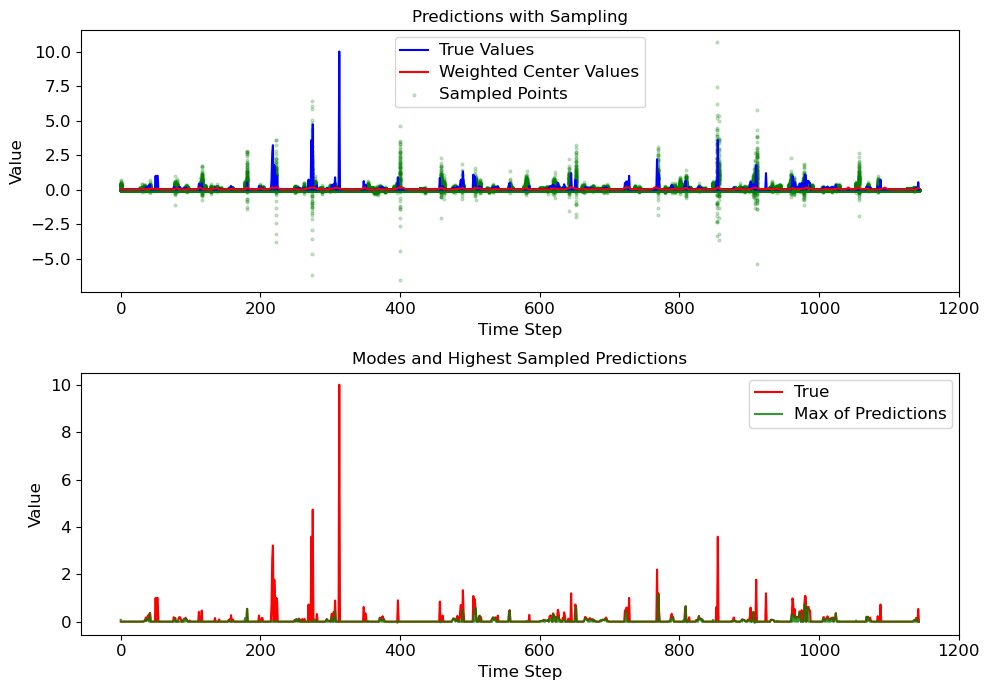

In [45]:
def visualize_combined_predictions(sampled_preds, expected_preds, true_vals, modes, samples):
    fig, axs = plt.subplots(2, 1, figsize=(10, 7))  # 1 row, 2 columns

    # First subplot: sampled predictions, expected predictions, and true values
    axs[0].plot(true_vals, label='True Values', color='blue')
    axs[0].plot(expected_preds, label='Weighted Center Values', color='red')
    for i, val in enumerate(sampled_preds):
        axs[0].scatter([i] * len(val), val, alpha=0.2, s=4, color='green', label='Sampled Points' if i == 0 else "")
    
    handles, labels = axs[0].get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    axs[0].legend(*zip(*unique))
    axs[0].set_title('Predictions with Sampling')
    axs[0].set_xlabel('Time Step')
    axs[0].set_ylabel('Value')
    # axs[0].set_xlim(0, 1000)
    mpl_functions.set_fontsize(axs[0], 14)
    
    # Second subplot: modes, highest samples, and true values
    axs[1].plot(true_vals, label='True', color='red')
    axs[1].plot(samples, label='Max of Predictions', alpha=0.8, color='green') 
    # axs[1].plot(modes, label='Modes', color='blue')  
    axs[1].set_title('Modes and Highest Sampled Predictions')
    axs[1].set_xlabel('Time Step')
    axs[1].set_ylabel('Value')
    axs[1].legend()
    # axs[1].set_xlim(600, 1000)
    mpl_functions.set_fontsize(axs[1], 12)
    fig.tight_layout()
    
# visualize_combined_predictions(sampled_preds_test, expected_preds_test, targets_test_np, modes, highest_samples) ## Maximum of the sampled values
visualize_combined_predictions(sampled_preds_test, expected_preds_test, targets_test_np, modes, closest_samples) ## Nearest to the true value

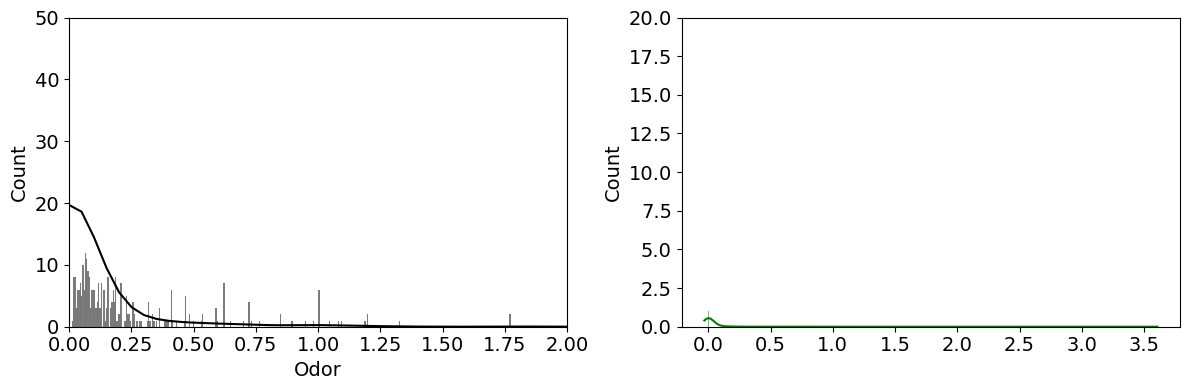

In [21]:
f,ax=plt.subplots(1,2,figsize=(12,4))
sns.histplot(targets_test_np, label='Actual Samples', kde=True, color='black',ax=ax[0])
# sns.histplot(modes, label='Mode/$\mu$ of the distribution', kde=True,  color='blue', ax=ax[1])
sns.histplot(closest_samples, label='Highest peak of the distribution', kde=True,  color='green', ax=ax[1])

ax[0].set_xlabel('Odor')

ax[0].set_ylim(0,50)
ax[0].set_xlim(0,2)
ax[1].set_ylim(0,20)
mpl_functions.set_fontsize(ax[0], 14)
mpl_functions.set_fontsize(ax[1], 14)
# ax[0].legend()
# ax[1].legend()
f.tight_layout()

In [46]:
test = pd.read_hdf(fp)
# m = scale_data(max_values)
padding_length = len(test) - len(highest_samples)

predicted_sample_padded = np.pad(highest_samples, (0, padding_length), 'constant', constant_values=(0))
test['predicted_odor'] = predicted_sample_padded

In [113]:
test.loc[test['odor'] > 0, 'odor'] = 1
test.loc[test['predicted_odor'] > 0, 'predicted_odor'] = 1

In [47]:
# test['scaled_odor']=scale_data(test.odor)
query='odor>0.5'
df = test.query(query)
df.reset_index(drop=True, inplace=True)

query1='predicted_odor>0.5'
df1 = test.query(query1)
df1.reset_index(drop=True, inplace=True)

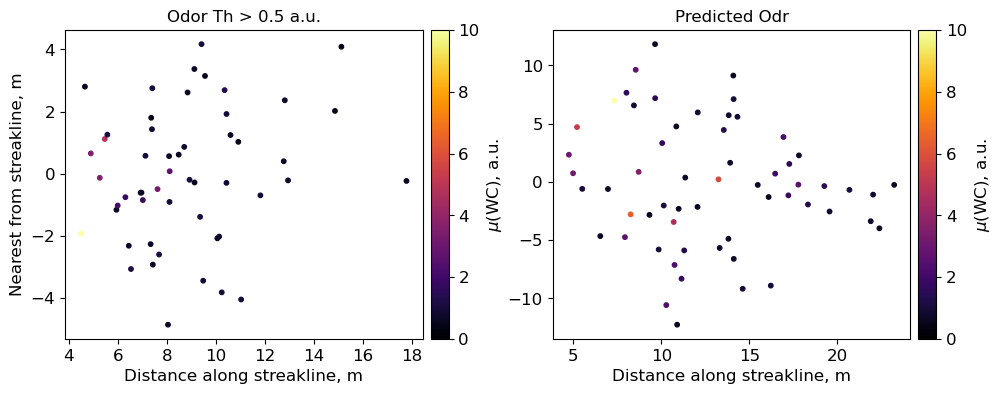

In [49]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
v = ax1.scatter(df.distance_along_streakline, df.nearest_from_streakline, c=df.odor, 
             s=10, cmap='inferno', vmin=0,vmax=10)

ax1.set_title('Odor Th > 0.5 a.u.')
ax1.set_ylabel('Nearest from streakline, m')
ax1.set_xlabel('Distance along streakline, m')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(v, cax=cax, orientation = 'vertical')
cbar.solids.set(alpha=1)
cbar.set_label('$\mu$(WC), a.u.')

w = ax2.scatter(df1.distance_along_streakline, df1.nearest_from_streakline, c=df1.predicted_odor, 
             s=10, cmap='inferno', vmin=0,vmax=10)

ax2.set_title('Predicted Odr')
# ax2.set_ylabel('Distance from source, m')
ax2.set_xlabel('Distance along streakline, m')
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(w, cax=cax, orientation = 'vertical')
cbar.solids.set(alpha=1)
cbar.set_label('$\mu$(WC), a.u.')

f.tight_layout(pad=1)
mpl_functions.set_fontsize(f, 12)

In [50]:
x=pd.read_hdf('/home/beast/An/data/Sept13Plumes/plume1/train_raw/diag21.h5')
def calculate_distance_from_source(df):
    source = np.array([[0,0]])
    odor_position = np.array([[df.x[i],df.y[i]] for i in range (len(df))]) 

    distance_from_source = np.array([cdist(odor_position,source)]).flatten()
    df['distance_from_source'] = distance_from_source
    
    
calculate_distance_from_source(x)

In [51]:
store = np.array(x.distance_from_source.iloc[100:])

In [52]:
test['distance_from_source']=store

In [53]:
osc.get_time_col(test,0.3)
# osc.calculate_distance_from_source(test)

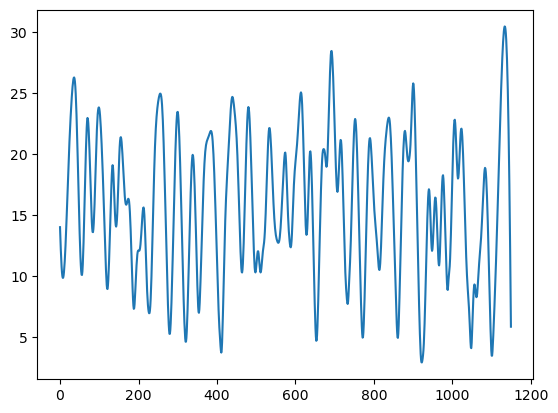

In [54]:
plt.plot(test.distance_from_source)


In [55]:
def mean_conc(df,index,dat):
    #Distance
    i = 0
    mean_concentration = []
    while i<len(index):
        mean_concentration.append(np.mean(df.odor[index[i]])) 
        i+=1
    dat['mean_concentration']=mean_concentration

def cal_stat(df,index, index_predicted,fdf, fdf_predicted):
    osc.avg_distance(df,index,fdf)
    osc.whiff_blank_duration(df,index,fdf)
    mean_conc(df,index,fdf)
    
    osc.avg_distance(df,index_predicted,fdf_predicted)
    osc.whiff_blank_duration(df,index_predicted,fdf_predicted)
    
    osc.predicted_mean_conc(df,index_predicted,fdf_predicted)

np.seterr(divide='ignore')
index = osc.get_index(test.odor,0.5)
index_predicted = osc.get_index(test.predicted_odor,1)
fdf = pd.DataFrame()
fdf_predicted = pd.DataFrame()

cal_stat(test,index,index_predicted,fdf, fdf_predicted)

fdf.keys()

Index(['avg_dist_from_source', 'log_avg_dist_from_source',
       'length_of_encounter', 'odor_intermittency', 'log_whiff', 'log_blank',
       'mean_concentration'],
      dtype='object')

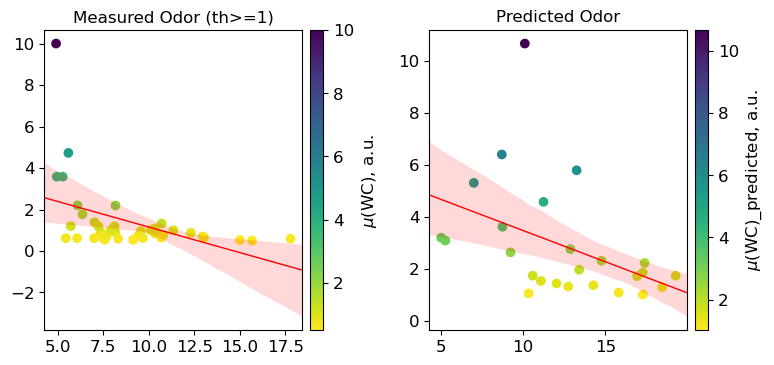

In [56]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(8,4))
var = ax1.scatter(fdf.avg_dist_from_source,fdf.mean_concentration, c=fdf.mean_concentration, cmap='viridis_r' )
ax1.set_ylabel('$\mu$(WC), a.u.')
ax1.set_xlabel('Distance from source , m')
ax1.set_title('Measured Odor (th>=1)')

g1 = sns.regplot(x=fdf.avg_dist_from_source,y=fdf.mean_concentration , data=fdf,
            ax=ax1, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(var, cax=cax, orientation = 'vertical')
cbar.solids.set(alpha=1)
cbar.set_label('$\mu$(WC), a.u.')


u=ax2.scatter(fdf_predicted.avg_dist_from_source,
              fdf_predicted.mean_concentration_p, 
              c=fdf_predicted.mean_concentration_p, cmap='viridis_r' )
# ax2.set_ylabel('Whiff Concentration, a.u.')
ax2.set_xlabel('Distance from source , m')
ax2.set_title('Predicted Odor')

g2 = sns.regplot(x=fdf_predicted.avg_dist_from_source,y=fdf_predicted.mean_concentration_p , data=fdf_predicted,
            ax=ax2, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(u, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC)_predicted, a.u.')

f.tight_layout(pad=2)

mpl_functions.set_fontsize(f, 12)
# f.savefig('../assets/300_ensemble_full.jpeg', dpi=150, bbox_inches = "tight")

Checking distribution of odor data - file sept13plumes/plume1/diag21.h5

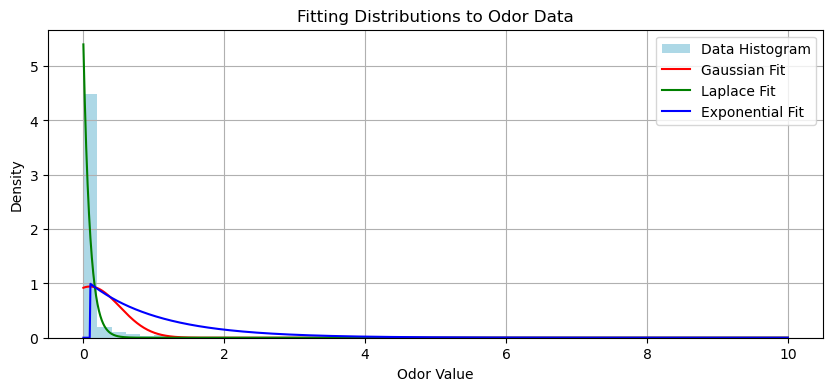

In [24]:
from scipy.stats import norm, laplace, expon

df =pd.read_hdf(fp)
# Data from the 'odor' column
data = df['odor'].values

mu, std = norm.fit(data)
b, loc = laplace.fit(data)
lam = 1. / data.mean()

x = np.linspace(data.min(), data.max(), 1000)


pdf_gaussian = norm.pdf(x, mu, std)
pdf_laplace = laplace.pdf(x, b, loc)
pdf_exponential = expon.pdf(x, 1./lam)

plt.figure(figsize=(10, 4))
weights = np.ones_like(data) / float(len(data))
plt.hist(data, bins=50, weights=weights, label='Data Histogram', color='lightblue', density=True)

plt.plot(x, pdf_gaussian, label='Gaussian Fit', color='red')
plt.plot(x, pdf_laplace, label='Laplace Fit', color='green')
plt.plot(x, pdf_exponential, label='Exponential Fit', color='blue')

plt.title('Fitting Distributions to Odor Data')
plt.xlabel('Odor Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()
